The Dataset I chose for this assignment was classification data for alzheimers. Found here https://www.kaggle.com/datasets/ankushpanday1/alzheimers-prediction-dataset-global

This dataset is more complex than the previous datasets I have used, there are a larger number of features that are less correlated as well as more datapoints to consider overall. Hopefully by doing so I can see the benefit of having a NN that is able to identify the correlation between the features and hopefully gain a fairly accurate predictor due to that.

In [49]:
import random
import math
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_rel
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler, GridSearchCV, cross_val_score, StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from mlxtend.evaluate import bias_variance_decomp

# Import the dataset
df = pd.read_csv("alzheimers_prediction_dataset.csv")
print(df)

            Country  Age  Gender  Education Level   BMI  \
0             Spain   90    Male                1  33.0   
1         Argentina   72    Male                7  29.9   
2      South Africa   86  Female               19  22.9   
3             China   53    Male               17  31.2   
4            Sweden   58  Female                3  30.0   
...             ...  ...     ...              ...   ...   
74278        Russia   60  Female                3  22.6   
74279            UK   58    Male               18  30.6   
74280         Spain   57  Female               13  28.2   
74281        Brazil   73  Female                7  29.0   
74282        Norway   57  Female                1  31.7   

      Physical Activity Level Smoking Status Alcohol Consumption Diabetes  \
0                      Medium          Never        Occasionally       No   
1                      Medium         Former               Never       No   
2                        High        Current        Occasion

In [50]:
# Initial Findings and start of EDA
df.info()
print("\nUnique Values\n", df.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74283 entries, 0 to 74282
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               74283 non-null  object 
 1   Age                                   74283 non-null  int64  
 2   Gender                                74283 non-null  object 
 3   Education Level                       74283 non-null  int64  
 4   BMI                                   74283 non-null  float64
 5   Physical Activity Level               74283 non-null  object 
 6   Smoking Status                        74283 non-null  object 
 7   Alcohol Consumption                   74283 non-null  object 
 8   Diabetes                              74283 non-null  object 
 9   Hypertension                          74283 non-null  object 
 10  Cholesterol Level                     74283 non-null  object 
 11  Family History 

In [51]:
# Seperate Ordinal data from non Ordinal data, Label Encode Ordinal Data and one hot encode non ordinal
# ie, high medium low is orginal, country of origin isnt
label_encode_cols = [
    "Gender", "Physical Activity Level", "Smoking Status", "Alcohol Consumption",
    "Cholesterol Level", "Family History of Alzheimer’s", "Depression Level",
    "Sleep Quality", "Dietary Habits", "Air Pollution Exposure", "Social Engagement Level",
    "Income Level", "Stress Levels", "Urban vs Rural Living",
    "Genetic Risk Factor (APOE-ε4 allele)", "Alzheimer’s Diagnosis"
]

one_hot_encode_cols = [
    "Country", "Diabetes", "Hypertension", "Employment Status", "Marital Status"
]

for col in label_encode_cols:
    label_encoder = preprocessing.LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col])

    
one_hot_encoder = preprocessing.OneHotEncoder(drop="first", sparse_output=False)
# Fit and transform
one_hot_encoded = one_hot_encoder.fit_transform(df[one_hot_encode_cols])
# Convert back to DataFrame with appropriate column names
one_hot_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_encode_cols))

df_encoded = pd.concat([df, one_hot_df], axis=1)

df_encoded.drop(columns=one_hot_encode_cols, inplace=True)
df_encoded = df_encoded.astype(float)

print(df_encoded)

        Age  Gender  Education Level   BMI  Physical Activity Level  \
0      90.0     1.0              1.0  33.0                      2.0   
1      72.0     1.0              7.0  29.9                      2.0   
2      86.0     0.0             19.0  22.9                      0.0   
3      53.0     1.0             17.0  31.2                      1.0   
4      58.0     0.0              3.0  30.0                      0.0   
...     ...     ...              ...   ...                      ...   
74278  60.0     0.0              3.0  22.6                      0.0   
74279  58.0     1.0             18.0  30.6                      1.0   
74280  57.0     0.0             13.0  28.2                      2.0   
74281  73.0     0.0              7.0  29.0                      1.0   
74282  57.0     0.0              1.0  31.7                      1.0   

       Smoking Status  Alcohol Consumption  Cholesterol Level  \
0                 2.0                  1.0                1.0   
1                

In [52]:
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 
    return A, cache

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0
    
    return dZ

def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

class NeuralNetwork:
    def __init__(self, layer_dimensions=[25, 16, 16, 1], learning_rate=0.00001):
        self.layer_dimensions = layer_dimensions
        self.learning_rate = learning_rate
        
        
    def initialize_parameters(self):
        np.random.seed(3)
        self.n_layers = len(self.layer_dimensions)
        for l in range(1, self.n_layers):
            setattr(self, f'W{l}', np.random.randn(self.layer_dimensions[l], self.layer_dimensions[l-1]) * 0.01)
            setattr(self, f'b{l}', np.zeros((self.layer_dimensions[l], 1)))
    
    
    def _linear_forward(self, A, W, b):
        Z = np.dot(W, A) + b
        cache = (A, W, b)
        return Z, cache
    
    
    def _forward_propagation(self, A_prev, W, b, activation):
        Z, linear_cache = self._linear_forward(A_prev, W, b)
        if activation == "sigmoid":
            A, activation_cache = sigmoid(Z)
        elif activation == "relu":
            A, activation_cache = relu(Z)
        cache = (linear_cache, activation_cache)
        return A, cache
    
    
    def forward_propagation(self, X):
        caches = []
        A = X
        L = self.n_layers - 1
        for l in range(1, L):
            A_prev = A 
            W = getattr(self, f'W{l}')
            b = getattr(self, f'b{l}')
            A, cache = self._forward_propagation(A_prev, W, b, "relu")
            caches.append(cache)
        W = getattr(self, f'W{L}')
        b = getattr(self, f'b{L}')
        predictions, cache = self._forward_propagation(A, W, b, "sigmoid")
        caches.append(cache)
        return predictions, caches
    
    
    def compute_cost(self, predictions, y):
        m = y.shape[0]
        cost = (-1/m) * (np.dot(y, np.log(predictions + 1e-9).T) + np.dot((1 - y), np.log(1 - predictions + 1e-9).T))
        cost = np.squeeze(cost)
        return cost   
    
    
    def _linear_backward(self, dZ, cache):
        A_prev, W, b = cache
        m = A_prev.shape[1]
        dW = (1/m) * np.dot(dZ, A_prev.T)
        db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)
        return dA_prev, dW, db
    
    
    def _back_propagation(self, dA, cache, activation):
        linear_cache, activation_cache = cache
        if activation == "relu":
            dZ = relu_backward(dA, activation_cache)
        elif activation == "sigmoid":
            dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = self._linear_backward(dZ, linear_cache)
        return dA_prev, dW, db
    
    
    def back_propagation(self, predictions, Y, caches):
        L = self.n_layers - 1
        m = predictions.shape[1]
        Y = Y.reshape(predictions.shape)
        dAL = - (np.divide(Y, predictions + 1e-9) - np.divide(1 - Y, 1 - predictions + 1e-9))
        current_cache = caches[L-1]
        dA_prev, dW, db = self._back_propagation(dAL, current_cache, "sigmoid")
        setattr(self, f'dW{L}', dW)
        setattr(self, f'db{L}', db)
        setattr(self, f'dA{L-1}', dA_prev)
        
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_curr = getattr(self, f'dA{l + 1}')
            dA_prev, dW, db = self._back_propagation(dA_curr, current_cache, "relu")
            setattr(self, f'dW{l+1}', dW)
            setattr(self, f'db{l+1}', db)
            setattr(self, f'dA{l}', dA_prev)
    
    
    def update_parameters(self):
        L = self.n_layers - 1
        for l in range(L):
            W = getattr(self, f'W{l+1}')
            dW = getattr(self, f'dW{l+1}')
            b = getattr(self, f'b{l+1}')
            db = getattr(self, f'db{l+1}')
            setattr(self, f'W{l+1}', W - self.learning_rate * dW)
            setattr(self, f'b{l+1}', b - self.learning_rate * db)
    

    def create_mini_batches(X, Y, batch_size, seed=42):
        m = X.shape[1]
        mini_batches = []
        np.random.seed(seed)
        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]
        if len(Y.shape) == 1:
            Y = Y.reshape(1, m)
        else:
            Y = Y[:, permutation]
        
        num_complete_batches = m // batch_size
        for k in range(num_complete_batches):
            mini_batch_X = shuffled_X[:, k * batch_size:(k + 1) * batch_size]
            mini_batch_Y = Y[:, k * batch_size:(k + 1) * batch_size]
            mini_batches.append((mini_batch_X, mini_batch_Y))
        
        if m % batch_size != 0:
            mini_batch_X = shuffled_X[:, num_complete_batches * batch_size:]
            mini_batch_Y = Y[:, num_complete_batches * batch_size:]
            mini_batches.append((mini_batch_X, mini_batch_Y))
            
        return mini_batches
    
    
    def fit(self, X, Y, epochs=2000, batch_size=None, print_cost=True):
        # Transpose X so that its shape is (n_x, m)
        X = X.T
        # Ensure Y is a row vector with shape (1, m)
        if len(Y.shape) == 1:
            Y = Y.reshape(1, -1)
        else:
            Y = Y.T
        
        np.random.seed(1)
        m = X.shape[1]
        self.initialize_parameters()
        
        # If no batch size is provided, use full-batch gradient descent.
        if batch_size is None:
            batch_size = m
        
        costs = []
        for i in range(epochs):
            # Shuffle and partition into mini-batches
            mini_batches = NeuralNetwork.create_mini_batches(X, Y, batch_size, seed=i)
            epoch_cost = 0
            for mini_X, mini_Y in mini_batches:
                predictions, caches = self.forward_propagation(mini_X)
                cost = self.compute_cost(predictions, mini_Y)
                epoch_cost += cost * mini_X.shape[1]  # Sum cost weighted by number of examples in batch
                self.back_propagation(predictions, mini_Y, caches)
                self.update_parameters()
            # Average cost over all examples in the epoch
            epoch_cost /= m
            
            if print_cost and i % 500 == 0:
                print("Cost after iteration {}: {}".format(i, np.squeeze(epoch_cost)))
                costs.append(epoch_cost)
        
        if print_cost:
            fig = px.line(y=np.squeeze(costs), title='Cost', template="plotly_dark")
            fig.update_layout(
                title_font_color="#00F1FF", 
                xaxis=dict(color="#00F1FF"), 
                yaxis=dict(color="#00F1FF")
            )
            fig.show()
    
    
    def predict(self, X, y):
        X = X.T
        predictions, _ = self.forward_propagation(X)
        predictions = (predictions > 0.5)
        predictions = np.squeeze(predictions.astype(int))
        accuracy = np.sum((predictions == y)) / X.shape[1]
        return accuracy, predictions.T


def train_evaluate_model(X_train, y_train, X_test, y_test, learning_rate, layer_dimensions, epochs, batch_size=None):
    model = NeuralNetwork(learning_rate=learning_rate, layer_dimensions=layer_dimensions)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, print_cost=False)
    accuracy, predictions = model.predict(X_test, y_test)
    eval_df = [learning_rate, layer_dimensions, epochs, batch_size, accuracy]
    return eval_df

In [53]:
X = df_encoded.drop("Alzheimer’s Diagnosis", axis=1).values  # Features
Y = df_encoded["Alzheimer’s Diagnosis"].values  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
print(f"Training data: {X_train.shape} {y_train.shape}")
print(f"Test data: {X_test.shape} {y_test.shape}")

layers = [44,20,1]
results = train_evaluate_model(X_train, y_train, X_test, y_test, learning_rate=0.001, layer_dimensions=layers, epochs=20, batch_size=128)
print(f"results:\nLR {results[0]}\nLayers {results[1]}\nEpochs {results[2]}\nBatch Size {results[3]}\nAccuracy {results[4]}")

Training data: (63140, 44) (63140,)
Test data: (11143, 44) (11143,)
results:
LR 0.001
Layers [44, 20, 1]
Epochs 20
Batch Size 128
Accuracy 0.6530557300547429


After implementing 

a. Initialization method.
b. Forward propagation method that performs forward propagation calculations.
c. Backward propagation method that implements the backpropagation algorithm
discussed in class.
d. Train method that includes the code for gradient descent.
e. Cost method that calculates the loss function.
f. Predict method that calculates the predictions for the test set.

I see that the runtime is definetly in need of optimization and my result is barely useful as an accurate predictor. I did learn a ton about encoding the data to be usable and clean through this process. Mainly the difference between One Hot encoding and Label encoding, and where they are applicable. I tried to implement a way for stochastic, mini-batch, and batch to be used in the NN from scratch during the training process. There was no real division of the data besides setting test/train, no cross validation or regularization.

In [54]:
# Now with any deep learning framework
import torch
import copy
import torch.nn as nn
import torch.optim as optim
import tqdm
from bayes_opt import BayesianOptimization

In [55]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74283 entries, 0 to 74282
Data columns (total 45 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   74283 non-null  float64
 1   Gender                                74283 non-null  float64
 2   Education Level                       74283 non-null  float64
 3   BMI                                   74283 non-null  float64
 4   Physical Activity Level               74283 non-null  float64
 5   Smoking Status                        74283 non-null  float64
 6   Alcohol Consumption                   74283 non-null  float64
 7   Cholesterol Level                     74283 non-null  float64
 8   Family History of Alzheimer’s         74283 non-null  float64
 9   Cognitive Test Score                  74283 non-null  float64
 10  Depression Level                      74283 non-null  float64
 11  Sleep Quality  

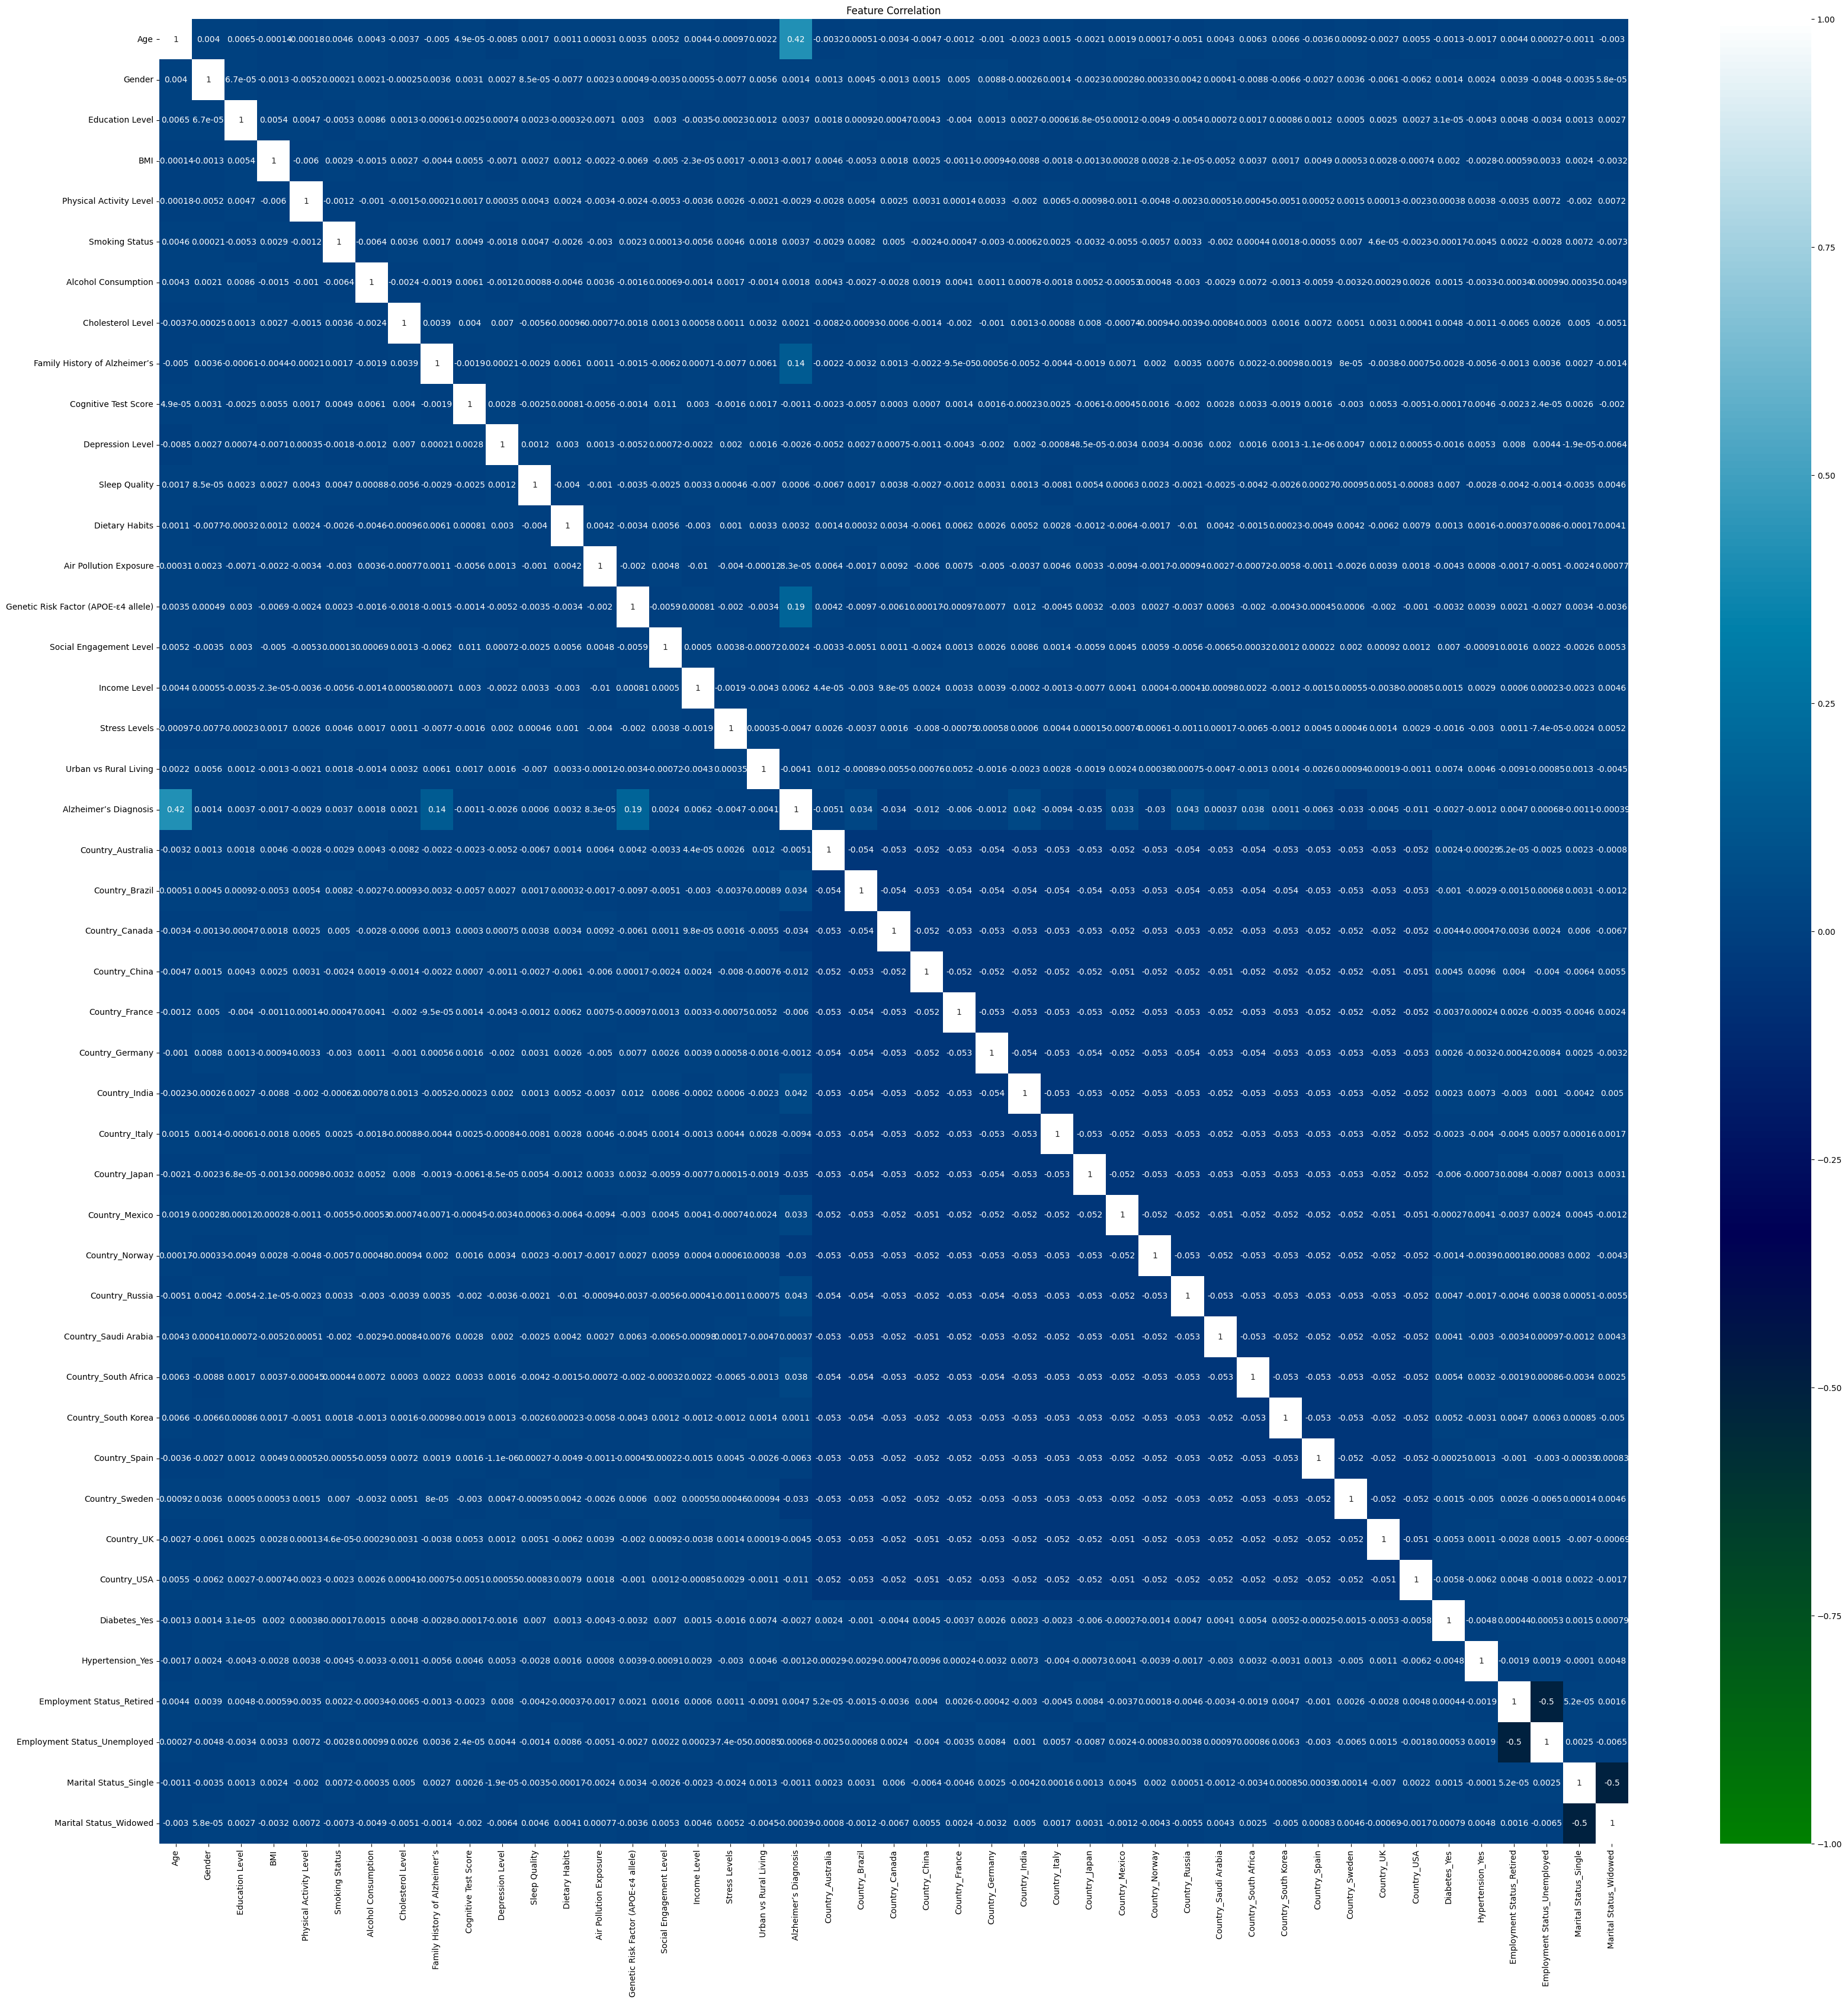

In [56]:
# Assuming df is your original DataFrame
print(df_encoded.info())
print(df_encoded.describe())

plt.figure(figsize=(40,40))
sns.heatmap(df_encoded.corr(), annot=True, cmap='ocean', vmin=-1, vmax=1)
plt.title("Feature Correlation")
plt.show()


In [57]:
vif_data = pd.DataFrame()
vif_data['Feature'] = df_encoded.columns
vif_data["VIF"] = [variance_inflation_factor(df_encoded.values, i) for i in range(len(df_encoded.columns))]

print(vif_data)

                                 Feature        VIF
0                                    Age  28.347398
1                                 Gender   1.979464
2                        Education Level   3.645299
3                                    BMI  24.288164
4                Physical Activity Level   2.463253
5                         Smoking Status   2.462343
6                    Alcohol Consumption   2.465426
7                      Cholesterol Level   3.270886
8          Family History of Alzheimer’s   1.455637
9                   Cognitive Test Score  10.379253
10                      Depression Level   2.474552
11                         Sleep Quality   2.469421
12                        Dietary Habits   2.461509
13                Air Pollution Exposure   2.458330
14  Genetic Risk Factor (APOE-ε4 allele)   1.299914
15               Social Engagement Level   2.479484
16                          Income Level   2.461754
17                         Stress Levels   2.478276
18          

In [58]:
Yt = torch.tensor(df_encoded["Alzheimer’s Diagnosis"], dtype=torch.float32).reshape(-1, 1)

# Normalize inputs for cleaner data
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
Xt = torch.tensor(X_scaled, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(Xt, Yt, train_size=0.85, shuffle=True)

In [59]:
def create_model(hidden_units):
    class Deep(nn.Module):
        def __init__(self):
            super().__init__()
            self.hidden1 = nn.Linear(44, hidden_units)
            self.act1 = nn.ReLU()
            self.hidden2 = nn.Linear(hidden_units, hidden_units)
            self.act2 = nn.ReLU()
            self.output = nn.Linear(hidden_units, 1)
            self.act_output = nn.Sigmoid()
    
        def forward(self, x):
            x = self.act1(self.hidden1(x))
            x = self.act2(self.hidden2(x))
            x = self.act_output(self.output(x))
            return x
    
    return Deep().to(device)

In [ ]:
def model_train(model, X_train, y_train, X_val, y_val, lr, batch_size):
    loss_fn = nn.BCELoss()  # Binary Cross Entropy loss
    optimizer = optim.Adam(model.parameters(), lr=lr)
    n_epochs = 250  # Use a smaller number for hyperparameter tuning

    best_acc = -np.inf
    best_weights = None

    # **Convert the validation data to the same device as the model**
    X_val = X_val.to(device)
    y_val = y_val.to(device)
    
    # Create batch indices (X_train and y_train are assumed to be tensors)
    batch_start = torch.arange(0, len(X_train), int(batch_size))
    
    for epoch in range(n_epochs):
        model.train()
        for start in batch_start:
            # For each batch, move the data to the device
            X_batch = X_train[start:start+int(batch_size)].to(device)
            y_batch = y_train[start:start+int(batch_size)].to(device)
            
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Evaluate on the validation set at the end of each epoch
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            acc = (y_val_pred.round() == y_val).float().mean().item()
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    
    # Restore the best weights and return the best validation accuracy
    model.load_state_dict(best_weights)
    return best_acc

# The objective function for Bayesian Optimization
def objective(lr, batch_size, hidden_units):
    # Convert parameters from floats to the appropriate types
    lr = float(lr)
    batch_size = int(round(batch_size))
    hidden_units = int(round(hidden_units))
    
    # Create the model (it is sent to device within create_model)
    model = create_model(hidden_units)
    
    # Train the model and obtain validation accuracy.
    # Note: We use X_train, y_train for training and X_test, y_test as the validation set.
    # Ensure that X_train, y_train, X_test, and y_test are already torch.Tensors.
    val_acc = model_train(model, X_train, y_train, X_test, y_test, lr, batch_size)
    
    print(f"lr: {lr}, batch_size: {batch_size}, hidden_units: {hidden_units} --> val_acc: {val_acc}")
    return val_acc


In [66]:
# Define the hyperparameter search space
pbounds = {
    'lr': (1e-5, 1e-2),
    'batch_size': (32, 128),   # These values will be rounded to integers
    'hidden_units': (16, 128)
}

# Instantiate the Bayesian Optimization object
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)

# Run the optimization
optimizer.maximize(init_points=5, n_iter=15)

# Print the best result
print("Best hyperparameters found:")
print(optimizer.max)

|   iter    |  target   | batch_... | hidden... |    lr     |
-------------------------------------------------------------
lr: 0.007322619478695937, batch_size: 68, hidden_units: 122 --> val_acc: 0.7150677442550659
| 1         | 0.7151    | 67.96     | 122.5     | 0.007323  |
lr: 0.0015683852581586646, batch_size: 89, hidden_units: 33 --> val_acc: 0.7167728543281555
| 2         | 0.7168    | 89.47     | 33.47     | 0.001568  |
lr: 0.006015138967314656, batch_size: 38, hidden_units: 113 --> val_acc: 0.7176702618598938
| 3         | 0.7177    | 37.58     | 113.0     | 0.006015  |
lr: 0.009699399423098323, batch_size: 100, hidden_units: 18 --> val_acc: 0.7208112478256226
| 4         | 0.7208    | 99.97     | 18.31     | 0.009699  |
lr: 0.0018264314223989354, batch_size: 112, hidden_units: 40 --> val_acc: 0.7194651365280151
| 5         | 0.7195    | 111.9     | 39.78     | 0.001826  |
lr: 0.006405789851626382, batch_size: 112, hidden_units: 40 --> val_acc: 0.7171318531036377
| 6         |

KeyboardInterrupt: 

In [67]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# Most Optimal parameters found by bayesian optimization
# lr: 0.009699399423098323, batch_size: 100, hidden_units: 18 --> val_acc: 0.7221574187278748
# | 4         | 0.7222    | 99.97     | 18.31     | 0.009699  |

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = create_model(18)
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr=0.0097, batch_size=100)
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

Accuracy (deep): 0.72
Accuracy (deep): 0.72
Accuracy (deep): 0.72
Accuracy (deep): 0.71
Accuracy (deep): 0.72
Deep: 72.07% (+/- 0.33%)


I had to do intensive research on PyTorch in order to implement this Neural Network, I used the docs supplied in the homework pdf as well as the PyTorch docs. I also read some articles about applying PyTorch and Deep Learning Frameworks that helped me optimize this to the best of my ability. I found many functions that were imperative to the handling of data and making the caclulation to produce a solid result. I applied bayesion optimization to try and find the best set of hyperparameters for my model. The tradeoff of runtime and accuracy was not ideal, the optimization algorithm took longer to run than the actual model itself, although it did result in roughly a 3% increase in accuracy. I did implement cross-validation with Stratified Kfold, this helped to provide a more sound outcome compared to keeping the same split of the dataset. As for an optimizer I implemented Adam since it paired well with the bayesian optimization for the hyperparameters. Overall the outcome I reached wasn't 100% ideal, although I familiarized myself with new techniques and i'm excited to apply them in the future with a better feel for why I am making the decision I am.